In [63]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import juanfit
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval,
            AsinhStretch)
from astropy.wcs import WCS
import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, FixedLocator, 
                               FixedFormatter, LogLocator, StrMethodFormatter)
import h5py
import copy
import scipy
from scipy.io import readsav
import sunpy
import sunpy.map
aia_171_cm = plt.get_cmap("sdoaia193")
aia_211_cm = plt.get_cmap("sdoaia211")

In [2]:
FeXIV_PSI_file = "../../sav/PSI_MAS/psi_special_Eclipse2017_Final_fe14_5303.fits"
FeX_PSI_file = "../../sav/PSI_MAS/psi_special_Eclipse2017_Final_fe10_6374.fits"
FeXIV_Kcorona_file = "../../sav/PSI_MAS/psi_Eclipse2017_Final_B_raw_mu010.fits"
FeX_Kcorona_file = "../../sav/PSI_MAS/psi_Eclipse2017_Final_B_raw_mu005.fits"

In [3]:
with fits.open(FeXIV_PSI_file) as hdul:
    FeXIV_PSI_header = hdul[0].header
    FeXIV_PSI_data = hdul[0].data

with fits.open(FeX_PSI_file) as hdul:
    FeX_PSI_header = hdul[0].header
    FeX_PSI_data = hdul[0].data

In [4]:
FeXIV_PSI_header

SIMPLE  =                    T / Written by IDL:  Mon Feb 14 17:48:51 2022      
BITPIX  =                  -32 / Real*4 (floating point)                        
NAXIS   =                    2 /                                                
NAXIS1  =                 2000 /                                                
NAXIS2  =                 2000 /                                                
DATE_OBS= '2017-08-21T17:18:17.6Z' /                                            
T_REC   = '2017-08-21T17:18:17.6Z' /                                            
T_OBS   = '2017-08-21T17:18:17.6Z' /                                            
OBSRVTRY= 'PSI-MAS Forward Model' /                                             
INSTRUME= 'Ground  '           /                                                
TELESCOP= 'Ground  '           /                                                
DETECTOR= 'fe14_5303'          /                                                
IMG_TYPE= 'model   '        

In [5]:
FeXIV_PSI_extent = [(0.5 - FeXIV_PSI_header["CRPIX1"])*FeXIV_PSI_header["CDELT1"] + FeXIV_PSI_header["CRVAL1"],
                    (0.5 + FeXIV_PSI_header["NAXIS1"] - FeXIV_PSI_header["CRPIX1"])*FeXIV_PSI_header["CDELT1"] + FeXIV_PSI_header["CRVAL1"],
                    (0.5 - FeXIV_PSI_header["CRPIX2"])*FeXIV_PSI_header["CDELT2"] + FeXIV_PSI_header["CRVAL2"],
                    (0.5 + FeXIV_PSI_header["NAXIS2"] - FeXIV_PSI_header["CRPIX2"])*FeXIV_PSI_header["CDELT2"] + FeXIV_PSI_header["CRVAL2"]]

FeX_PSI_extent = [(0.5 - FeX_PSI_header["CRPIX1"])*FeX_PSI_header["CDELT1"] + FeX_PSI_header["CRVAL1"],
                    (0.5 + FeX_PSI_header["NAXIS1"] - FeX_PSI_header["CRPIX1"])*FeX_PSI_header["CDELT1"] + FeX_PSI_header["CRVAL1"],
                    (0.5 - FeX_PSI_header["CRPIX2"])*FeX_PSI_header["CDELT2"] + FeX_PSI_header["CRVAL2"],
                    (0.5 + FeX_PSI_header["NAXIS2"] - FeX_PSI_header["CRPIX2"])*FeX_PSI_header["CDELT2"] + FeX_PSI_header["CRVAL2"]]

In [6]:
FeXIV_wcs = WCS(FeXIV_PSI_header)
FeX_wcs = WCS(FeX_PSI_header)

In [39]:
rsun_arcsec_PSI = FeXIV_PSI_header["RSUN_OBS"]

In [7]:
FeXIV_AWSoM_file = "../../sav/AWSoM/syn_fit/box_run0034_run01_75_5th/FeXIV_530_synspec_emiss.h5"
FeX_AWSoM_file = "../../sav/AWSoM/syn_fit/box_run0034_run01_75_5th/FeX_637_synspec_emiss.h5"

In [13]:
with h5py.File(FeXIV_AWSoM_file, 'r') as hf:
    FeXIV_AWSoM_data = hf["fit_matrix"][:]
    awsom_x = hf['awsom_x'][:]
    awsom_y = hf['awsom_y'][:]
    awsom_z =  hf['awsom_z'][:]

with h5py.File(FeX_AWSoM_file, 'r') as hf:
    FeX_AWSoM_data = hf["fit_matrix"][:]

In [24]:
awsom_z_grid, awsom_y_grid, awsom_x_grid = np.meshgrid(awsom_z,awsom_y,awsom_x,indexing="ij")

FeXIV_AWSoM_data_mask_TR = copy.copy(FeXIV_AWSoM_data)
FeX_AWSoM_data_mask_TR = copy.copy(FeX_AWSoM_data)
mask_transition_region_fit = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2)[:,:,np.newaxis]* \
                        np.ones_like(FeXIV_AWSoM_data_mask_TR) <= 1.03) 
FeXIV_AWSoM_data_mask_TR[mask_transition_region_fit] = np.nan
FeX_AWSoM_data_mask_TR[mask_transition_region_fit] = np.nan

In [40]:
AWSoM_extent = [awsom_y[0]-0.005 ,awsom_y[-1]+0.005,awsom_z[0]-0.005,awsom_z[-1]+0.005]
AWSoM_extent_arcsec = np.array(AWSoM_extent)*rsun_arcsec_PSI

In [58]:
AWSoM_AIA_file = "../../sav/AWSoM/syn_fit/box_run0034_run01_75_5th/los_sdo_aia_6_n0100000.sav"
AWSoM_AIA_sav = readsav(AWSoM_AIA_file)

In [59]:
AWSoM_AIA_sav["varname"]

b'AIA:94 AIA:131 AIA:171 AIA:193 AIA:211 AIA:304 AIA:335 XRT:Al-mesh XRT:Al-poly XRT:Ti-poly'

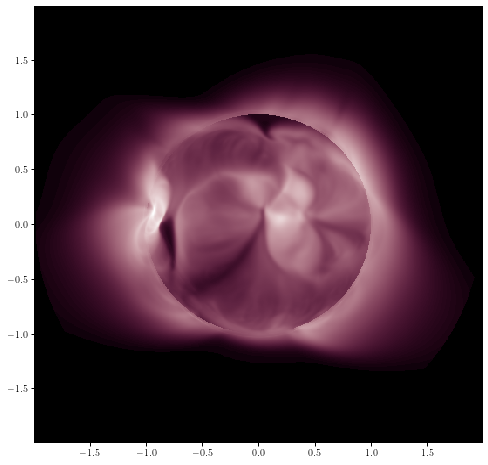

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
norm_AWSoM_AIA_211 = ImageNormalize(AWSoM_AIA_sav["w"][4],stretch=AsinhStretch(0.01))
ax.pcolormesh(AWSoM_AIA_sav["x"][0],AWSoM_AIA_sav["x"][1],AWSoM_AIA_sav["w"][4],
              cmap=aia_211_cm,norm=norm_AWSoM_AIA_211)

In [9]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

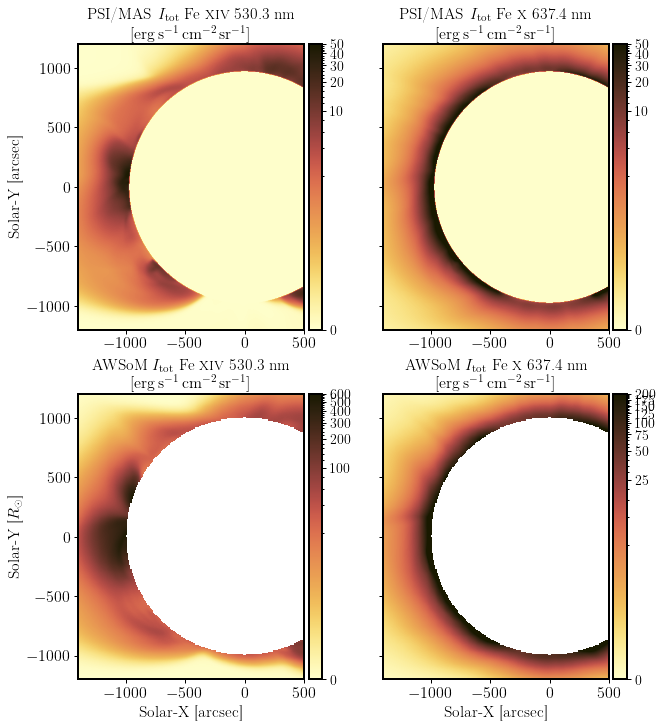

In [46]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,10),constrained_layout=True)

norm_FeXIV_PSI = ImageNormalize(FeXIV_PSI_data*2,vmin=0,vmax=50,stretch=LogStretch())
im1 = ax1.imshow(FeXIV_PSI_data*2,norm=norm_FeXIV_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeXIV_PSI_extent)
plot_colorbar(im1,ax1,width="6%")
ax1.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax1.set_ylabel("Solar-Y [arcsec]",fontsize=16)

norm_FeX_PSI = ImageNormalize(FeX_PSI_data*2,vmin=0,vmax=50,stretch=LogStretch())
im2 = ax2.imshow(FeX_PSI_data*2,norm=norm_FeX_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeX_PSI_extent)
plot_colorbar(im2,ax2,width="6%")
ax2.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax2.tick_params(labelleft=False)


norm_FeXIV_AWSoM = ImageNormalize(FeXIV_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=600,stretch=LogStretch())
im3 = ax3.imshow(FeXIV_AWSoM_data_mask_TR[:,:,1],norm=norm_FeXIV_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax3.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)

ax3.set_ylabel("Solar-Y [$R_\odot$]",fontsize=16)
plot_colorbar(im3,ax3,width="6%")

norm_FeX_AWSoM = ImageNormalize(FeX_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=200,stretch=LogStretch())
im4 = ax4.imshow(FeX_AWSoM_data_mask_TR[:,:,1],norm=norm_FeX_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax4.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax4.tick_params(labelleft=False)
plot_colorbar(im4,ax4,width="6%")



for ax_ in (ax1,ax2):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    

for ax_ in (ax3,ax4):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    ax_.set_xlabel("Solar-X [arcsec]",fontsize=16)






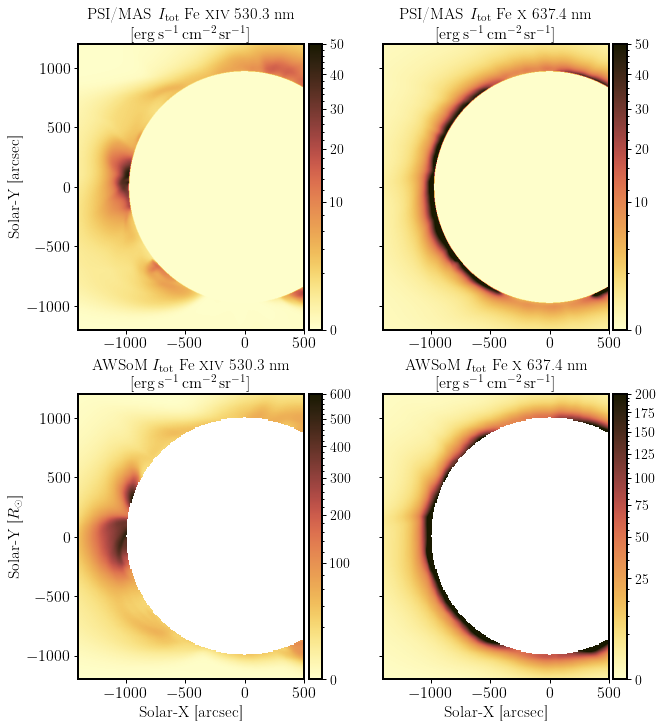

In [45]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,10),constrained_layout=True)

norm_FeXIV_PSI = ImageNormalize(FeXIV_PSI_data*2,vmin=0,vmax=50,stretch=SqrtStretch())
im1 = ax1.imshow(FeXIV_PSI_data*2,norm=norm_FeXIV_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeXIV_PSI_extent)
plot_colorbar(im1,ax1,width="6%")
ax1.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax1.set_ylabel("Solar-Y [arcsec]",fontsize=16)

norm_FeX_PSI = ImageNormalize(FeX_PSI_data*2,vmin=0,vmax=50,stretch=SqrtStretch())
im2 = ax2.imshow(FeX_PSI_data*2,norm=norm_FeX_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeX_PSI_extent)
plot_colorbar(im2,ax2,width="6%")
ax2.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax2.tick_params(labelleft=False)


norm_FeXIV_AWSoM = ImageNormalize(FeXIV_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=600,stretch=SqrtStretch())
im3 = ax3.imshow(FeXIV_AWSoM_data_mask_TR[:,:,1],norm=norm_FeXIV_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax3.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)

ax3.set_ylabel("Solar-Y [$R_\odot$]",fontsize=16)
plot_colorbar(im3,ax3,width="6%")

norm_FeX_AWSoM = ImageNormalize(FeX_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=200,stretch=SqrtStretch())
im4 = ax4.imshow(FeX_AWSoM_data_mask_TR[:,:,1],norm=norm_FeX_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax4.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax4.tick_params(labelleft=False)
plot_colorbar(im4,ax4,width="6%")



for ax_ in (ax1,ax2):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    

for ax_ in (ax3,ax4):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    ax_.set_xlabel("Solar-X [arcsec]",fontsize=16)






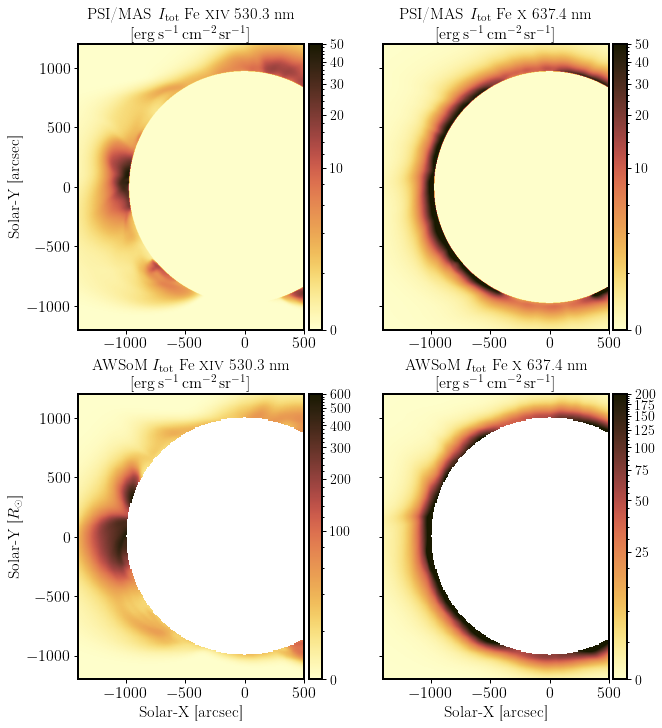

In [52]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,10),constrained_layout=True)

norm_FeXIV_PSI = ImageNormalize(FeXIV_PSI_data*2,vmin=0,vmax=50,stretch=AsinhStretch(0.05))
im1 = ax1.imshow(FeXIV_PSI_data*2,norm=norm_FeXIV_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeXIV_PSI_extent)
plot_colorbar(im1,ax1,width="6%")
ax1.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax1.set_ylabel("Solar-Y [arcsec]",fontsize=16)

norm_FeX_PSI = ImageNormalize(FeX_PSI_data*2,vmin=0,vmax=50,stretch=AsinhStretch(0.05))
im2 = ax2.imshow(FeX_PSI_data*2,norm=norm_FeX_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeX_PSI_extent)
plot_colorbar(im2,ax2,width="6%")
ax2.set_title(r"PSI/MAS $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax2.tick_params(labelleft=False)


norm_FeXIV_AWSoM = ImageNormalize(FeXIV_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=600,stretch=AsinhStretch(0.05))
im3 = ax3.imshow(FeXIV_AWSoM_data_mask_TR[:,:,1],norm=norm_FeXIV_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax3.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)

ax3.set_ylabel("Solar-Y [$R_\odot$]",fontsize=16)
plot_colorbar(im3,ax3,width="6%")

norm_FeX_AWSoM = ImageNormalize(FeX_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=200,stretch=AsinhStretch(0.05))
im4 = ax4.imshow(FeX_AWSoM_data_mask_TR[:,:,1],norm=norm_FeX_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax4.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax4.tick_params(labelleft=False)
plot_colorbar(im4,ax4,width="6%")



for ax_ in (ax1,ax2):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    

for ax_ in (ax3,ax4):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    ax_.set_xlabel("Solar-X [arcsec]",fontsize=16)






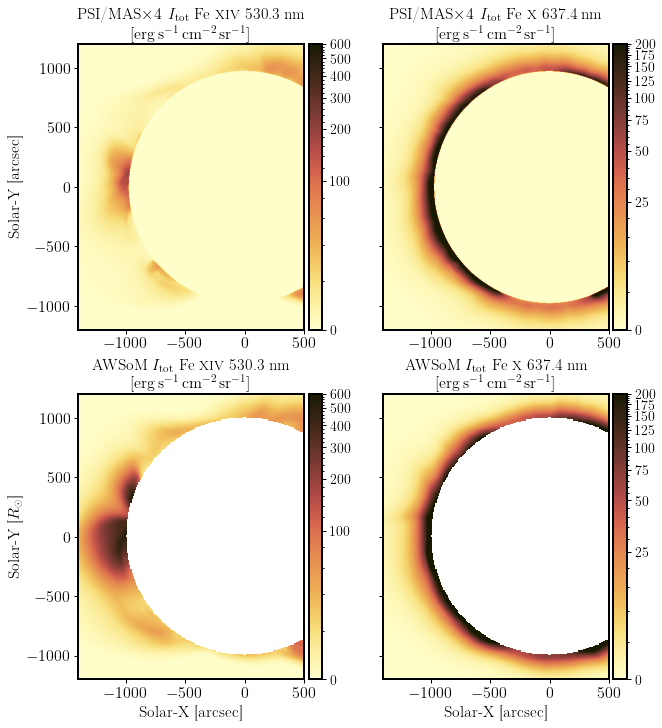

In [54]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,10),constrained_layout=True)

norm_FeXIV_PSI = ImageNormalize(FeXIV_PSI_data*2*4,vmin=0,vmax=600,stretch=AsinhStretch(0.05))
im1 = ax1.imshow(FeXIV_PSI_data*2*4,norm=norm_FeXIV_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeXIV_PSI_extent)
plot_colorbar(im1,ax1,width="6%")
ax1.set_title(r"PSI/MAS$\times 4$ $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax1.set_ylabel("Solar-Y [arcsec]",fontsize=16)

norm_FeX_PSI = ImageNormalize(FeX_PSI_data*2*4,vmin=0,vmax=200,stretch=AsinhStretch(0.05))
im2 = ax2.imshow(FeX_PSI_data*2*4,norm=norm_FeX_PSI,cmap=cmcm.lajolla,origin="lower",
           extent = FeX_PSI_extent)
plot_colorbar(im2,ax2,width="6%")
ax2.set_title(r"PSI/MAS$\times 4$ $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax2.tick_params(labelleft=False)


norm_FeXIV_AWSoM = ImageNormalize(FeXIV_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=600,stretch=AsinhStretch(0.05))
im3 = ax3.imshow(FeXIV_AWSoM_data_mask_TR[:,:,1],norm=norm_FeXIV_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax3.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{xiv} 530.3 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)

ax3.set_ylabel("Solar-Y [$R_\odot$]",fontsize=16)
plot_colorbar(im3,ax3,width="6%")

norm_FeX_AWSoM = ImageNormalize(FeX_AWSoM_data_mask_TR[:,:,1],vmin=0,vmax=200,stretch=AsinhStretch(0.05))
im4 = ax4.imshow(FeX_AWSoM_data_mask_TR[:,:,1],norm=norm_FeX_AWSoM,
    cmap=cmcm.lajolla, origin="lower", extent=AWSoM_extent_arcsec)

ax4.set_title(r"AWSoM $I_{\rm tot}$ Fe \textsc{x} 637.4 nm"+"\n"+\
              r"$\mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=16)
ax4.tick_params(labelleft=False)
plot_colorbar(im4,ax4,width="6%")



for ax_ in (ax1,ax2):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    

for ax_ in (ax3,ax4):
    ax_.set_xlim(-1400,500)
    ax_.set_ylim(-1200,1200)
    ax_.tick_params(labelsize=16)
    ax_.set_xlabel("Solar-X [arcsec]",fontsize=16)




